# RECOMMENDATION SYSTEM

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
from collections import Counter
from collections import defaultdict
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

## Surprise Library ready to used prediction algorithms
from surprise import SVD
from surprise import SVDpp
from surprise import Reader
from surprise import SlopeOne
from surprise import NMF
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering
from surprise import accuracy
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="invalid value encountered in greater")
warnings.filterwarnings("ignore", message="invalid value encountered in less_equal")
warnings.filterwarnings("ignore", message="invalid value encountered in less")
warnings.filterwarnings("ignore", message="divide by zero encountered in divide")

## Input Data 

In [2]:
## Read Book Data Information
df_books = pd.read_csv('C:/Data/BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1",low_memory=False)
df_books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

## Read User Data Information
df_users = pd.read_csv('C:/Data/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1", low_memory=False)
df_users.columns = ['userID', 'Location', 'Age']

## Read Ratings Data Information
df_ratings = pd.read_csv('C:/Data/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1", low_memory=False)
df_ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\nSkipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\nSkipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\nSkipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


# Exploratory Data Analysis

In [3]:
## View the first few records in df_users
df_users.head()

userID                            Location   Age
0       1                  nyc, new york, usa   NaN
1       2           stockton, california, usa  18.0
2       3     moscow, yukon territory, russia   NaN
3       4           porto, v.n.gaia, portugal  17.0
4       5  farnborough, hants, united kingdom   NaN

In [4]:
## View the number of cols and rows
df_users.shape

(278858, 3)

In [5]:
## View the different unique ages in df_users
print(df_users.Age.unique())

[ nan  18.  17.  61.  26.  14.  25.  19.  46.  55.  32.  24.  20.  34.
  23.  51.  31.  21.  44.  30.  57.  43.  37.  41.  54.  42.  50.  39.
  53.  47.  36.  28.  35.  13.  58.  49.  38.  45.  62.  63.  27.  33.
  29.  66.  40.  15.  60.   0.  79.  22.  16.  65.  59.  48.  72.  56.
  67.   1.  80.  52.  69.  71.  73.  78.   9.  64. 103. 104.  12.  74.
  75. 231.   3.  76.  83.  68. 119.  11.  77.   2.  70.  93.   8.   7.
   4.  81. 114. 230. 239.  10.   5. 148. 151.   6. 101. 201.  96.  84.
  82.  90. 123. 244. 133.  91. 128.  94.  85. 141. 110.  97. 219.  86.
 124.  92. 175. 172. 209. 212. 237.  87. 162. 100. 156. 136.  95.  89.
 106.  99. 108. 210.  88. 199. 147. 168. 132. 159. 186. 152. 102. 116.
 200. 115. 226. 137. 207. 229. 138. 109. 105. 228. 183. 204.  98. 223.
 113. 208. 107. 157. 111. 146. 118. 220. 143. 140. 189. 127.]


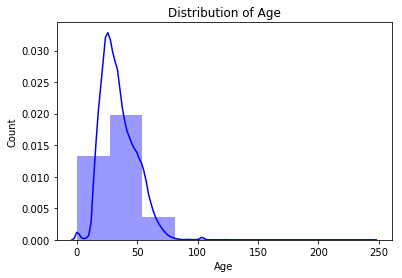

In [6]:
## Look at age distribution by binning the age

plt.title("Distribution of Age")
plt.xlabel('Age')
plt.ylabel('Count')
sns.distplot(df_users["Age"], bins=9, color="blue")

# Save the graph
plt.savefig('distage.png', bbox_inches= 'tight')

In [7]:
## View he first few records in df_ratings
df_ratings.head()

userID        ISBN  bookRating
0  276725  034545104X           0
1  276726  0155061224           5
2  276727  0446520802           0
3  276729  052165615X           3
4  276729  0521795028           6

In [8]:
## View the number of cols and rows
df_ratings.shape

(1149780, 3)

In [212]:
## Produce a interactive graph of the bookRatings
init_notebook_mode(connected=True)
data = df_ratings['bookRating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df_ratings.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )

# Create layout
layout = dict(title = 'Distribution Of {} Book Ratings'.format(df_ratings.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [10]:
## View some records in df_books
df_books.head()

ISBN                                          bookTitle  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

             bookAuthor yearOfPublication                   publisher  \
0    Mark P. O. Morford              2002     Oxford University Press   
1  Richard Bruce Wright              2001       HarperFlamingo Canada   
2          Carlo D'Este              1991             HarperPerennial   
3      Gina Bari Kolata              1999        Farrar Straus Giroux   
4       E. J. W. Barber              1999  W. W. Norton &amp; Company   

                                           imageUrlS  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   
3  http://images.amazon.com/images/P/0374157065.0...   
4  http://images.amazon.com/images/P/0393045218.0...   

                                           imageUrlM  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   
3  http://images.amazon.com/images/P/0374157065.0...   
4  http://images.amazon.com/images/P/0393045218.0...   

                                           imageUrlL  
0  http://images.amazon.com/images/P/0195153448.0...  
1  http://images.amazon.com/images/P/0002005018.0...  
2  http://images.amazon.com/images/P/0060973129.0...  
3  http://images.amazon.com/images/P/0374157065.0...  
4  http://images.amazon.com/images/P/0393045218.0...

In [11]:
## View the number of cols and rows
df_books.shape

(271360, 8)

In [12]:
## Check for missing ISBN & BookTitles

print('Checking for missing ISBN Numbers ', df_books['ISBN'].isnull().sum())
print('Checking for missing Book Titles', df_books['bookTitle'].isnull().sum())


Checking for missing ISBN Numbers  0
Checking for missing Book Titles 0


In [13]:
## Get a number of users and books to assess a potential matrix size

n_users = df_users.shape[0]
n_books = df_books.shape[0]

print("Number of Users", n_users)
print("Number of Books", n_books)
print("Size of Uers * Books", n_users * n_books)

Number of Users 278858
Number of Books 271360
Size of Uers * Books 75670906880


In [14]:
## Ratings should exist only when a book exists in the file
df_ratings_new = df_ratings[df_ratings.ISBN.isin(df_books.ISBN)]

orig_rat = df_ratings.shape[0]
new_rat = df_ratings_new.shape[0]
diff_rat = orig_rat - new_rat
print('Number of records with a rating with no associated book {0}'.format(diff_rat))

Number of records with a rating with no associated book 118644


In [15]:
## Get size of the new ratings dataframe after removal of ratings with no associated books
df_ratings_new.shape

(1031136, 3)

In [16]:
## Merge the books and the ratings data frames
book_rating_mrg = pd.merge(df_ratings_new,df_books,on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor','imageUrlS','imageUrlM','imageUrlL']

#Remove columns that are not needed
book_rating_mrg = book_rating_mrg.drop(columns,axis=1)
book_rating_mrg.head()

userID        ISBN  bookRating             bookTitle
0  276725  034545104X           0  Flesh Tones: A Novel
1    2313  034545104X           5  Flesh Tones: A Novel
2    6543  034545104X           0  Flesh Tones: A Novel
3    8680  034545104X           5  Flesh Tones: A Novel
4   10314  034545104X           9  Flesh Tones: A Novel

In [17]:
## View the size of the newly merged dataset
book_rating_mrg.shape

(1031136, 4)

In [18]:
## Get the Total Rating Count for each ISBN
book_ratingCount = (book_rating_mrg.
     groupby(by = ['ISBN'])['bookRating'].
     count().
     reset_index().
     rename(columns = {'bookRating': 'totalRatingCount'})
     [['ISBN', 'totalRatingCount']]
    )
book_ratingCount.count()

ISBN                270151
totalRatingCount    270151
dtype: int64

In [19]:
## Get the Total Rating Count for each UserID
ratingCount_userID = (book_rating_mrg.
     groupby(by = ['userID'])['bookRating'].
     count().
     reset_index().
     sort_values('bookRating', ascending=False)
    )
ratingCount_userID.count()

userID        92106
bookRating    92106
dtype: int64

In [122]:
## Produce a interactive graph of the bookRatings by UserID
data = book_rating_mrg.groupby('userID')['bookRating'].count().clip(upper=70)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 70,
                                  size = 2))

# Create layout
layout = go.Layout(title = 'Distribution of Ratings Counts (showing only a portion)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.1)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [21]:
## Add the total rating count on each book
rating_with_totalRatingCount = book_rating_mrg.merge(book_ratingCount, 
                                                    left_on = 'ISBN', 
                                                    right_on = 'ISBN', 
                                                    how = 'left')
rating_with_totalRatingCount.count()

userID              1031136
ISBN                1031136
bookRating          1031136
bookTitle           1031136
totalRatingCount    1031136
dtype: int64

In [22]:
## Check the sparsity of dataset
sparsity=1.0-len(rating_with_totalRatingCount)/float(n_users*n_books)
sparsity = sparsity *100
print('The sparsity level of Book Crossing dataset is', sparsity)

The sparsity level of Book Crossing dataset is 99.99863734155898


In [23]:
rating_with_totalRatingCount[:7]

userID        ISBN  bookRating             bookTitle  totalRatingCount
0  276725  034545104X           0  Flesh Tones: A Novel                60
1    2313  034545104X           5  Flesh Tones: A Novel                60
2    6543  034545104X           0  Flesh Tones: A Novel                60
3    8680  034545104X           5  Flesh Tones: A Novel                60
4   10314  034545104X           9  Flesh Tones: A Novel                60
5   23768  034545104X           0  Flesh Tones: A Novel                60
6   28266  034545104X           0  Flesh Tones: A Novel                60

In [24]:
tot_grp_books = rating_with_totalRatingCount['totalRatingCount']

tot_grp_books.count()

1031136

In [25]:
## Bin the total ratings by book to see what can be reduced
filter_values = [0, 50, 100, 200, 300, 400, 500, 600, 700]   
total_bookrt_bin = pd.cut(tot_grp_books, bins=filter_values)
counts = pd.value_counts(total_bookrt_bin)
counts.sort_index()

(0, 50]       799260
(50, 100]      95453
(100, 200]     72321
(200, 300]     26650
(300, 400]     14593
(400, 500]      8866
(500, 600]      5982
(600, 700]      1876
Name: totalRatingCount, dtype: int64

In [26]:
## Remove the lower ratings group (0-50), to reduce the dataframe for computations purposes

rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= 50')
rating_popular_book.shape[0]

234876

In [27]:
## Reduce the dataset down to include usa users only

#Add the location to the dataframe
reduced = rating_popular_book.merge(df_users, left_on = 'userID', right_on = 'userID', how = 'left')

#Reduce down based on location
us_user_rating = reduced[reduced['Location'].str.contains("usa")]
us_user_rating=us_user_rating.drop('Age', axis=1)
us_user_rating.shape[0]

183913

In [28]:
# Remove the duplicate rows
if not us_user_rating[us_user_rating.duplicated(['userID', 'bookTitle'])].empty:
    initial_rows = us_user_rating.shape[0]

    print('Initial dataframe shape {0}'.format(us_user_rating.shape))
    us_user_rating = us_user_rating.drop_duplicates(['userID', 'bookTitle'])
    current_rows = us_user_rating.shape[0]
    print('New dataframe shape {0}'.format(us_user_rating.shape))
    print('Removed {0} rows'.format(initial_rows - current_rows))

Initial dataframe shape (183913, 6)
New dataframe shape (183123, 6)
Removed 790 rows


# Produce Recommendations

### 1) Produce simple popularity based recommendation system

In [30]:
#######  This is not a good way to provide recommendations as it will only
#######  choose those books that received the most recommendations but I wanted to test it

In [31]:
#Create a dataframe to calculate top 10 recommended books on popularity by ratings
us_rating_total = pd.DataFrame(us_user_rating.
     groupby(['ISBN'])['bookRating'].
     sum())
     
#Calculate top10 Recommended Books by popularity
top10_books = us_rating_total.sort_values('bookRating', ascending = False).head(10)
print("The Top10 Recommended Books By Popularity Ratings:")
df_top10 = pd.DataFrame(top10_books.merge(df_books, left_index = True, right_on = 'ISBN'))
df_top10 = df_top10[['ISBN', 'bookTitle', 'bookAuthor', 'bookRating']]
df_top10

The Top10 Recommended Books By Popularity Ratings:


ISBN                                          bookTitle  \
408   0316666343                          The Lovely Bones: A Novel   
748   0385504209                                  The Da Vinci Code   
522   0312195516                The Red Tent (Bestselling Backlist)   
2143  059035342X  Harry Potter and the Sorcerer's Stone (Harry P...   
356   0142001740                            The Secret Life of Bees   
1105  0060928336    Divine Secrets of the Ya-Ya Sisterhood: A Novel   
706   0446672211  Where the Heart Is (Oprah's Book Club (Paperba...   
118   0671027360                                Angels &amp; Demons   
305   044023722X                                    A Painted House   
231   0452282152                          Girl with a Pearl Earring   

           bookAuthor  bookRating  
408      Alice Sebold        4348  
748         Dan Brown        3327  
522     Anita Diamant        2463  
2143    J. K. Rowling        2400  
356     Sue Monk Kidd        2296  
1105    Rebecca Wells        2120  
706      Billie Letts        1847  
118         Dan Brown        1807  
305      John Grisham        1734  
231   Tracy Chevalier        1719

In [32]:
## CREATE ITEM - ITEM RATINGS MATRIX

In [33]:

# Pivot the reduced down data into a sparse matrix filling null values with 0

us_user_rating_pivot = us_user_rating.pivot(index = 'bookTitle', columns = 'userID', 
                                                          values = 'bookRating').fillna(0)

us_user_rating_matrix = csr_matrix(us_user_rating_pivot.values)

In [34]:
## Check the sparsity of the matrix

matrix_size = us_user_rating_matrix.shape[0]*us_user_rating_matrix.shape[1] # Number of possible interactions in the matrix
num_ratings = len(us_user_rating_matrix.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_ratings/matrix_size))
print("Matrix Size", matrix_size)
print("Number of Ratings",num_ratings)
print("Sparsity", sparsity)


Matrix Size 62128402
Number of Ratings 71827
Sparsity 99.88438942949152


In [35]:
## View the matrix
us_user_rating_pivot[:5]

userID               9       14      16      17      26      32      39      \
bookTitle                                                                     
16 Lighthouse Road      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1984                    0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1st to Die: A Novel     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2010: Odyssey Two       0.0     0.0     0.0     0.0     0.0     0.0     0.0   
204 Rosewood Lane       0.0     0.0     0.0     0.0     0.0     0.0     0.0   

userID               42      44      51      ...  278807  278813  278819  \
bookTitle                                    ...                           
16 Lighthouse Road      0.0     0.0     0.0  ...     0.0     0.0     0.0   
1984                    0.0     0.0     0.0  ...     0.0     0.0     0.0   
1st to Die: A Novel     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2010: Odyssey Two       0.0     0.0     0.0  ...     0.0     0.0     0.0   
204 Rosewood Lane       0.0     0.0     0.0  ...     0.0     0.0     0.0   

userID               278828  278832  278836  278843  278844  278851  278854  
bookTitle                                                                    
16 Lighthouse Road      0.0     0.0     0.0     0.0     0.0     0.0     0.0  
1984                    0.0     0.0     0.0     0.0     0.0     0.0     0.0  
1st to Die: A Novel     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2010: Odyssey Two       0.0     0.0     0.0     0.0     0.0     0.0     0.0  
204 Rosewood Lane       0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 31682 columns]

### 2) Produce KNN with cosine similarity recommendation system using scikit-nearest neighbors

In [36]:
## Train the model using the default of K=5

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'auto')
model_knn.fit(us_user_rating_matrix)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [193]:
## Find the 10 nearest neighbors of a random book to recommend books similar to other books
query_index = np.random.choice(us_user_rating_pivot.shape[0])
distances, indices = model_knn.kneighbors(us_user_rating_pivot.iloc[query_index, :].values.reshape(1, -1),
                                          n_neighbors = 8)

#Find a random book choice to make book recommendations by similarity                              
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Interview with the Vampire:

1: The Queen of the Damned (Vampire Chronicles (Paperback)), with distance of 0.6680863023074847:
2: The Tale of the Body Thief (Vampire Chronicles (Paperback)), with distance of 0.6741593558189494:
3: The Vampire Lestat (Vampire Chronicles, Book II), with distance of 0.6779704687248705:
4: Memnoch the Devil (Vampire Chronicles, No 5), with distance of 0.7836811395668626:
5: The Vampire Armand (The Vampire Chronicles, Book 6), with distance of 0.8062609739682929:
6: Vittorio the Vampire: New Tales of the Vampires, with distance of 0.8434377513901734:
7: Taltos: Lives of the Mayfair Witches, with distance of 0.8459627109401044:


### 3) Produce Singular Value Decomposition (Dimensionality Reduction) recommendation system using scikit Truncated SVD

In [38]:
## CREATE USER - ITEM RATINGS MATRIX

In [39]:
## Transpose the matrix to userID by BookTitle to create user-item ratings matrix
## SVD is performed on columns and we want to use UserId

us_user_rating_pivot_mv = us_user_rating.pivot(index = 'userID', columns = 'bookTitle', 
                                                          values = 'bookRating').fillna(0)
us_user_rating_pivot_mv[:5]



bookTitle  16 Lighthouse Road  1984  1st to Die: A Novel  2010: Odyssey Two  \
userID                                                                        
9                         0.0   0.0                  0.0                0.0   
14                        0.0   0.0                  0.0                0.0   
16                        0.0   0.0                  0.0                0.0   
17                        0.0   0.0                  0.0                0.0   
26                        0.0   0.0                  0.0                0.0   

bookTitle  204 Rosewood Lane  24 Hours  2nd Chance  3rd Degree  4 Blondes  \
userID                                                                      
9                        0.0       0.0         0.0         0.0        0.0   
14                       0.0       0.0         0.0         0.0        0.0   
16                       0.0       0.0         0.0         0.0        0.0   
17                       0.0       0.0         0.0         0.0        0.0   
26                       0.0       0.0         0.0         0.0        0.0   

bookTitle  50 Simple Things You Can Do to Save the Earth  ...  \
userID                                                    ...   
9                                                    0.0  ...   
14                                                   0.0  ...   
16                                                   0.0  ...   
17                                                   0.0  ...   
26                                                   0.0  ...   

bookTitle  Wuthering Heights (Penguin Classics)  \
userID                                            
9                                           0.0   
14                                          0.0   
16                                          0.0   
17                                          0.0   
26                                          0.0   

bookTitle  Wuthering Heights (Wordsworth Classics)  \
userID                                               
9                                              0.0   
14                                             0.0   
16                                             0.0   
17                                             0.0   
26                                             0.0   

bookTitle  Xenocide (Ender Wiggins Saga (Paperback))  YOU BELONG TO ME  \
userID                                                                   
9                                                0.0               0.0   
14                                               0.0               0.0   
16                                               0.0               0.0   
17                                               0.0               0.0   
26                                               0.0               0.0   

bookTitle  Year of Wonders  You Belong To Me  \
userID                                         
9                      0.0               0.0   
14                     0.0               0.0   
16                     0.0               0.0   
17                     0.0               0.0   
26                     0.0               0.0   

bookTitle  Zen and the Art of Motorcycle Maintenance: An Inquiry into Values  \
userID                                                                         
9                                                        0.0                   
14                                                       0.0                   
16                                                       0.0                   
17                                                       0.0                   
26                                                       0.0                   

bookTitle  Zoya  \O\" Is for Outlaw"  stardust  
userID                                          
9           0.0                  0.0       0.0  
14          0.0                  0.0       0.0  
16          0.0                  0.0       0.0  
17          0.0                  0.0       0.0  
26

In [40]:
## View the shape of the matrix
us_user_rating_pivot_mv.shape

(31682, 1961)

In [41]:
## Transpose the matrix
X = us_user_rating_pivot_mv.values.T
X.shape

(1961, 31682)

In [42]:
## Apply SVD with 10 components (categories) 
SVD = TruncatedSVD(n_components=10, random_state=17)
svd_matrix = SVD.fit_transform(X)


In [43]:
## View the shape of the reduced demensionality matrix
svd_matrix.shape

(1961, 10)

In [44]:
## Produce a correlation 
corr = np.corrcoef(svd_matrix)

In [45]:
## Apply the recommendations using SVD to a specific book to check the recommendations

us_book_title = us_user_rating_pivot_mv.columns
us_book_list = list(us_book_title)

# Get the index of the book "To Kill a Mockingbird"
sp_book = us_book_list.index("To Kill a Mockingbird")
print(sp_book)

1827


In [46]:
## Get a list of highly correlated books to "To Kill a Mockingbird" excluding the book itself
corr_sp_book = corr[sp_book]
list(us_book_title[(corr_sp_book > 0.9) & (corr_sp_book != 1)])

###### Seems to be working fairly well, similar books come up on Amazon recommendations ####

['A Wizard of Earthsea (Earthsea Trilogy, Book 1)',
 'American Gods',
 'Awakening',
 'Bless Me, Ultima',
 'Bloody Bones (Anita Blake Vampire Hunter (Paperback))',
 'Dandelion Wine (Grand Master Editions)',
 'Death of A Salesman',
 "Ender's Game (Ender Wiggins Saga (Paperback))",
 "Having Our Say : The Delany Sisters' First 100 Years",
 'High Fidelity',
 'Lion, the Witch and the Wardrobe',
 'Lord of the Flies',
 'Neverwhere',
 'Notes from a Small Island',
 'Rush Limbaugh Is a Big Fat Idiot: And Other Observations',
 'Sex &amp; the City',
 'Siddhartha',
 "Slaughterhouse Five or the Children's Crusade: A Duty Dance With Death",
 "Sophie's World: A Novel About the History of Philosophy",
 'Still Life with Woodpecker',
 'Sun Also Rises',
 'The Catcher in the Rye',
 'The Celestine Prophecy',
 'The Fountainhead',
 'The Great Gatsby',
 'The Indian in the Cupboard',
 'The Second Summer of the Sisterhood',
 'Their Eyes Were Watching God',
 'Things Fall Apart : A Novel']

### 4) Utilize the Surprise Library to analyze and build recommendations 

In [48]:
## Use the Reader class to parse a file that contains ratings
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(us_user_rating[['userID', 'ISBN', 'bookRating']], reader)

In [51]:
## Create a benchmark of algorithms available in the Surprise libary to see which one is the best
benchmark = []

# Iterate over all algorithms 
for algorithm in [SVD(), SVDpp(), NMF(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly()]:

    # Perform cross validation using 3-fold cross validation, measuring on Root Mean Square Error
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)

    # Create a dataframe of the results
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


test_rmse   fit_time  test_time
Algorithm                                     
BaselineOnly    3.576616   0.523197   0.344711
SVD             3.719463   6.137499   0.444281
KNNBaseline     3.728783  20.277108   6.987413
KNNWithMeans    3.795626  19.965530   6.615140
KNNWithZScore   3.807129  19.602926   6.889336
SVDpp           3.909236  94.185455   3.760853
NMF             4.003382   9.047606   0.320926
KNNBasic        4.064312  22.141400   5.745146

In [52]:
## Get the benchmarks in a dataframe for graph
b_mark = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  


In [120]:
## Produce a interactive graph of the testMSE from the Algorithmns
init_notebook_mode(connected=True)
data_grp = b_mark['test_rmse'].sort_values(ascending=True)
trace = go.Bar(x = data_grp.index,
               text = ['{:.1f} %'.format(val) for val in (data_grp.values)],
               textposition = 'auto',
               marker = dict(
                  color = 'rgb(153,204,205)',
                  line = dict(color = 'rgb(51,0,0)')),
               y = data_grp.values
               )

# Create layout
layout = dict(title = 'Algorithms by Test RMSE',
              xaxis = dict(title = 'Algorithm'),
              yaxis = dict(title = 'Test RMSE'))

# Create plot
fig = go.Figure(data=[trace], layout=layout)

iplot(fig)

In [54]:
##Use the BaselineOnly Algorithm since it had the lowest test_rmse with ALS method

print('Using ALS')
bsl_options = {'method': 'als',    #Alternating Least Squares
               'n_epochs': 5,      #The number of iteration of the ALS procedure
               'reg_u': 12,        #The regularization parameter for user
               'reg_i': 5          #The regularization parameter for items
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([3.57678766, 3.56593998, 3.55969237]),
 'fit_time': (0.28383922576904297, 0.35505247116088867, 0.36406445503234863),
 'test_time': (0.34177112579345703, 0.5024471282958984, 0.41121721267700195)}

In [55]:
trainset, testset = train_test_split(data, test_size=0.20)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 3.5412


3.541189429911496

In [56]:
## Produce a dataframe with predictions
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)


In [57]:
## View the top 10 users with the best predictions
best_predictions = df.sort_values(by='err')

best_predictions[:10]

uid         iid  rui  est                    details   Iu  Ui  err
13863  145619  1401088945  0.0  0.0  {'was_impossible': False}  106  40  0.0
14095    3363  0380701340  0.0  0.0  {'was_impossible': False}  117  27  0.0
23863  252071  0345422392  0.0  0.0  {'was_impossible': False}  128  38  0.0
33591  166123  0553572210  0.0  0.0  {'was_impossible': False}  198  51  0.0
15320    8936  0440209412  0.0  0.0  {'was_impossible': False}   92  46  0.0
9581    76352  0440224829  0.0  0.0  {'was_impossible': False}  541  45  0.0
35607   39646  0451202317  0.0  0.0  {'was_impossible': False}  174  45  0.0
9726   219546  0451203895  0.0  0.0  {'was_impossible': False}  136  97  0.0
18621  217375  0061098361  0.0  0.0  {'was_impossible': False}  262  41  0.0
1164   234623  0553278029  0.0  0.0  {'was_impossible': False}  253  51  0.0

In [58]:
## View the top 10 users with the worst predictions
worst_predictions = df.sort_values(by='err')

worst_predictions[-10:]

uid         iid   rui       est                    details   Iu  \
3850   228764  0449006344  10.0  0.437521  {'was_impossible': False}  120   
10033   69232  0440224810  10.0  0.404768  {'was_impossible': False}  146   
35534  195694  0345422384  10.0  0.345610  {'was_impossible': False}  169   
26557   51883  0425077047  10.0  0.344376  {'was_impossible': False}   90   
4486   227447  055356773X  10.0  0.316610  {'was_impossible': False}  307   
23556  238781  0743406184  10.0  0.300124  {'was_impossible': False}  188   
16063  238120  0385413041  10.0  0.269801  {'was_impossible': False}  344   
16069   14521  0553275976  10.0  0.192169  {'was_impossible': False}  182   
36486    8936  0399142282  10.0  0.157008  {'was_impossible': False}   92   
33022   24921  0440236665  10.0  0.107601  {'was_impossible': False}  106   

        Ui       err  
3850    39  9.562479  
10033   42  9.595232  
35534   58  9.654390  
26557   33  9.655624  
4486    56  9.683390  
23556   21  9.699876  
16063   39  9.730199  
16069  107  9.807831  
36486   43  9.842992  
33022   32  9.892399

# 5) Utilize the Surprise Library SVD to find the top 10 recommendation for each user 

In [59]:
## View the top 10 recommendations using Suprise library SVD algorithm

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [60]:
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(us_user_rating[['userID', 'ISBN', 'bookRating']], reader)

In [61]:
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

In [62]:
##Product the top 10 predictions for each user
top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, bookRating in top_n.items():
    print(uid, [iid for (iid, _) in bookRating])
    

276725 ['039480001X', '0618002219', '0618002227', '038548951X', '0877017883', '0439136350', '1400032717', '0446677450', '0385484518', '0679432477']
2313 ['0767902521', '0812550706', '0060392452', '0446677450', '0446601241', '0425129586', '0452269571', '1400034779', '0385199570', '0345369947']
6543 ['0553274295', '0380718340', '0345339703', '0385509456', '0679751602', '0446607657', '0060392452', '0312244266', '0140067477', '0345337662']
8680 ['0446677450', '0446310786', '0061097314', '038548951X', '0439139597', '0385505833', '0812550706', '0425163385', '0156528207', '0385504209']
10314 ['0064407667', '044651652X', '0894805770', '0553289691', '0345413350', '0312265867', '0877017883', '0439139597', '0671727796', '0740704818']
23768 ['0439139600', '0812550706', '1400032717', '0439136350', '0385199570', '0446532231', '0316781142', '0440212561', '0316678104', '0316693006']
28266 ['0786868716', '0385199570', '1400032717', '0345391802', '0618129022', '089480829X', '0553296981', '0439136350', '

111947 ['0060199652', '0446515078', '0375760911', '0345439104', '1573225789', '0590353403', '014028009X', '038542017X', '0345447867', '0553573403']
113155 ['0877017883', '1400032717', '0446310786', '0440215625', '0894808249', '0446532452', '0684814994', '055357258X', '0439136350', '0385199570']
123228 ['0449212602', '059035342X', '0380002930', '0345313860', '0345342968', '0743418174', '0441005489', '0451153553', '0385199570', '0345350685']
124869 ['0877017883', '0439136350', '0786866845', '0618002219', '0553272535', '0446520802', '0446310786', '0439064864', '0590353403', '014025448X']
124942 ['0440404193', '0345337662', '0670032379', '0385722435', '089480829X', '0375758992', '0684801523', '0312265859', '0441003257', '043935806X']
128208 ['0786817070', '0439136350', '0670894605', '0312983867', '0385503822', '1551668998', '0805063897', '0679457526', '0449911519', '0310205719']
134247 ['059035342X', '0553375407', '1592400876', '0439136350', '0439139600', '0439064864', '0842329250', '03851

46443 ['0811801802', '0316284955', '0380789035', '0671027344', '059035342X', '0590353403', '039480001X', '0740704818', '0385503822', '0877017883']
54349 ['0345342968', '0446677450', '0670894605', '0679731148', '0877017883', '0618129022', '0679751602', '015602943X', '0743227441', '043936213X']
67840 ['0446310786', '0446608955', '0060930535', '014038572X', '0061097314', '038542471X', '0385199570', '0312924585', '0553212583', '0060096195']
70379 ['0553272535', '0811801802', '0786868716', '0877017883', '1592400876', '0142001740', '0451526341', '0446605239', '0345342968', '0316969680']
70538 ['1558743669', '0385484518', '0553296981', '0446610399', '0786868716', '0812550706', '0156528207', '0060930187', '0743227441', '0385729332']
77886 ['0156528207', '0345350499', '0812550706', '0385199570', '039480001X', '0316779237', '0385510438', '0874776945', '0385335482', '0740704818']
84972 ['039480001X', '0439139597', '0590353403', '0670894605', '0743227441', '0439136350', '0446677450', '0375504613',

109082 ['0877017883', '1400032717', '0590353403', '043935806X', '039480001X', '0385474547', '0440215625', '059035342X', '0375758992', '0064471047']
121264 ['0590353403', '0316693200', '0805062971', '0060959037', '0743227441', '0439064864', '0877017883', '0812550706', '0446310786', '0553375407']
124876 ['0446520802', '0316666343', '059035342X', '0446672211', '0451169530', '1878424319', '0060959037', '0451526341', '0440487617', '0786817070']
128122 ['0439064864', '059035342X', '0689817851', '0671003755', '0425178102', '0811801802', '0312195516', '0142004235', '0452269571', '0446670251']
133296 ['0385503822', '0440414806', '0380702843', '0380710218', '0451177096', '014038572X', '0070212570', '0671004565', '0446605239', '0385472951']
134929 ['0439064872', '0670032379', '039480001X', '0399501487', '0553274295', '0440219078', '0670894605', '059035342X', '0439064864', '0590353403']
135376 ['0385504209', '0064407667', '0345443284', '0452282152', '0399501487', '0894808249', '0393317552', '03757

163187 ['0439139597', '0590353403', '0060392452', '0446310786', '0380001411', '0670894605', '0061097314', '0385504209', '0679785892', '0060199652']
163267 ['0142000663', '039480001X', '0743418174', '0316969443', '0385474547', '0449912558', '0439064864', '0316779490', '0688170528', '0060964049']
164276 ['039480001X', '0553272535', '0451524934', '043935806X', '0811801802', '0439064864', '0894808249', '0670894605', '0385199570', '0439136369']
165319 ['1558743669', '0553801376', '0345439104', '014100018X', '0316777722', '0590353403', '0345391802', '0060929871', '0312201656', '0385335482']
166722 ['0877017883', '039480001X', '0590353403', '039592720X', '014029628X', '0811825558', '068484267X', '0679785892', '0441790348', '0812550706']
166778 ['0590353403', '0618002219', '0345342968', '0446310786', '0449911519', '0439139597', '0156528207', '0805063889', '0439064864', '0618002227']
166813 ['0743418174', '0743227441', '0670032379', '0671027360', '0385199570', '0439064872', '0345342968', '04466

51687 ['039480001X', '0877017883', '0446677450', '0743227441', '0618002227', '0679785892', '0767902521', '0440219078', '0375756981', '0345339711']
55486 ['0345342968', '0385504209', '0440343194', '0440219078', '0385490445', '0671021001', '039480001X', '0671041789', '0425177173', '0553274295']
61072 ['0446672211', '0316666343', '0156528207', '0439064864', '0877017883', '1558743669', '1400032717', '0894808249', '0345339703', '0740704818']
76499 ['055356451X', '043935806X', '0064405176', '0440498058', '0060096195', '0385729340', '0345423402', '0440241537', '002542730X', '0345391810']
104337 ['043936213X', '0446677450', '039592720X', '0064400018', '0439136369', '0385504209', '039480001X', '059035342X', '0425129586', '0439139597']
119772 ['0439064864', '0385199570', '0590353403', '0439139597', '0439136369', '0451524934', '0670894605', '0805062971', '0671027344', '0399501487']
182623 ['0439064864', '0590353403', '0439136350', '0439136369', '0877017883', '0156528207', '0618002219', '067089460

136304 ['0375758992', '0618129022', '0440215625', '0385199570', '0446532452', '0811801802', '0439136350', '0385420161', '0618002227', '0156528207']
136747 ['043936213X', '1558745718', '0380789035', '0439136350', '0842329250', '0142001805', '0345342968', '0446310786', '0743457358', '059035342X']
136925 ['039592720X', '0590353403', '0439136350', '0439064864', '0439139597', '043935806X', '0446677450', '0786868716', '0060964049', '1592400876']
137981 ['0439139597', '0439136350', '043935806X', '034536676X', '0811801802', '0877017883', '0439064864', '059035342X', '0312263120', '0140430725']
138302 ['0439064864', '0743227441', '0439136350', '059035342X', '0439064872', '0679785892', '0618002219', '0877017883', '0385729332', '0618002227']
138780 ['039592720X', '0618002227', '0385199570', '0385504209', '0446677450', '038548951X', '0618002219', '0156528207', '0670032379', '0553274295']
138883 ['0440414806', '0553213105', '0345339711', '014038572X', '0877017883', '0451524934', '0684853523', '04390

53942 ['043936213X', '034536676X', '0877017883', '043935806X', '0312195516', '0679731148', '0380977788', '038548951X', '0345339681', '0553272535']
55933 ['0439064864', '0618002227', '0440219078', '039480001X', '0877017883', '0439139597', '0439064872', '0671776134', '0671041789', '0156528207']
57398 ['0060517794', '0385504209', '0312283709', '0345342968', '0345339681', '0439136369', '0553274295', '0740723367', '0553211404', '0553280414']
58342 ['0440219078', '0439139597', '0385199570', '0440498058', '0312983867', '0345441036', '0441172717', '0618002227', '0060959037', '0439136350']
63133 ['0446677450', '0671027344', '0312199430', '0385199570', '0440219078', '0618002227', '0812511816', '0380789035', '0439136350', '0064400018']
63568 ['0142004235', '0140053204', '0449912558', '0060915544', '0446677450', '0877017883', '038548951X', '0375406530', '039480001X', '0394820371']
63976 ['043935806X', '0449911519', '0142001740', '0441790348', '0439139597', '0451167716', '0064400557', '0877017883',

32703 ['043935806X', '0670894605', '0385199570', '039480001X', '0446364193', '0140067477', '0439136369', '0345339711', '0452269571', '0679457526']
59297 ['0385199570', '0446677450', '0439136350', '0316769487', '0446532452', '0671027344', '0446531332', '067102423X', '0670894605', '0440498058']
113364 ['0070212570', '0553274295', '0590353403', '0316666343', '0375758992', '0553279378', '0375702709', '0553272535', '0439136369', '0316769509']
114309 ['0812550706', '0553296981', '0618002227', '0618002219', '0590353403', '0618129022', '0740704818', '0312305060', '0446310786', '0451167716']
132290 ['0439064864', '0439139597', '0446677450', '0385504209', '0609608444', '0743227441', '0142004235', '0688170528', '0375400117', '0399149155']
135167 ['0743227441', '0451524934', '039480001X', '0345339681', '0451167716', '0786868716', '0811801802', '0618002227', '0590353403', '0345342968']
147841 ['0385484518', '043935806X', '0590353403', '0439064864', '039480001X', '0618002227', '0439139597', '0439136

24379 ['0385504209', '0446310786', '0312195516', '0449005615', '0345413350', '0618002219', '0385199570', '0375500510', '0345342968', '0553274295']
25253 ['0441172717', '1400031354', '043936213X', '0439139600', '0452269571', '0439139597', '0877017883', '0345402871', '0679746048', '0425182878']
25405 ['0670032379', '0743227441', '0385199570', '0452282152', '043935806X', '0156528207', '0316666343', '0345339738', '0316601950', '0894808249']
27878 ['0439136350', '043935806X', '0618002219', '0439064864', '0670032379', '0590353403', '0439139597', '0451524934', '0151008116', '0385199570']
28481 ['059035342X', '0553274295', '0385199570', '0440219078', '0671027344', '0439136369', '0156528207', '0446365386', '0439139597', '0451526341']
28548 ['0439136369', '0439139597', '0670032379', '043935806X', '0060938455', '039480001X', '0156027321', '0670894605', '0553296981', '0439139600']
29944 ['0060938455', '0060392452', '0805063889', '0451524934', '0553348981', '0553375407', '0385199570', '0156528207',

13380 ['0385199570', '0385504209', '0439136350', '0618129022', '059035342X', '0375703764', '0064471101', '014131088X', '0440212561', '0345384369']
15583 ['0812550706', '0553272535', '0743418174', '0316096199', '0375756981', '0451167716', '0894808249', '1400031354', '0060964049', '0446532452']
18714 ['039480001X', '0064400018', '0345339711', '0060928336', '0439136350', '0345339738', '0894805770', '0385199570', '038548951X', '0671027344']
19549 ['0140067477', '0877017883', '0894808249', '0811801802', '039480001X', '0670894605', '0740704818', '0345339681', '0385199570', '0156528207']
22624 ['059035342X', '0743227441', '0446677450', '0740704818', '0451167716', '0061097101', '0439064864', '0449911519', '0805063897', '0553375407']
22900 ['0590353403', '0316776963', '1400032717', '0380002930', '0812550706', '0618129022', '0060392452', '0439136350', '0345361792', '043935806X']
23799 ['0439139600', '0439136350', '0877017883', '0553274295', '0440219078', '0439136369', '0439064864', '1400032717',

123214 ['0385199570', '0451167716', '0375758992', '0877017883', '0440439884', '0446677450', '0316601950', '0894805770', '0894808249', '0064471047']
129543 ['0590353403', '0060392452', '1573225789', '1400032717', '067168390X', '0441790348', '0811801802', '0786868716', '0439136369', '038548951X']
130624 ['039480001X', '0142004235', '0375400117', '0743227441', '0805063897', '0156027321', '0345413369', '0440967694', '0802130208', '0375756981']
131941 ['039480001X', '038549081X', '0877017883', '0618002227', '0142000663', '0446677450', '0439064864', '0156528207', '043935806X', '0679785892']
133276 ['0740704818', '0439139597', '0020442203', '0618002227', '0671027344', '0439064864', '039480001X', '0671727796', '059035342X', '0439136369']
133744 ['0440219078', '0439136369', '0142004235', '0316666343', '0156528207', '0618129022', '0345342968', '0670894605', '0439136350', '0877017883']
134272 ['0439139597', '0439064872', '0679785892', '0553296981', '043935806X', '0439064864', '0451163966', '04391

51131 ['0805062971', '043935806X', '059035342X', '0385199570', '0316182540', '0439064864', '0671027344', '0439136369', '0439136350', '0439139597']
70024 ['039480001X', '0740704818', '0439064864', '0811801802', '0449912558', '0316769487', '0439139597', '0802130208', '0805062971', '0446672211']
93872 ['0590353403', '0446520802', '0446611867', '0439064864', '0451166892', '0439136350', '0439139600', '0380789035', '0439064872', '0877017883']
99239 ['0439136350', '039480001X', '059035342X', '0439064864', '043935806X', '0590353403', '0439139597', '0805062971', '0060959037', '0446672211']
144186 ['0446610038', '059035342X', '0312195516', '0684801523', '0439064864', '0452269571', '0670032379', '0451163966', '0671776134', '039480001X']
161499 ['0451167716', '0439136369', '0679785892', '0743227441', '0553296981', '0446677450', '0877017883', '0671250671', '0440180295', '0671776134']
168500 ['0446610399', '0894803204', '0894808249', '0877017883', '0684801523', '0786868716', '0590353403', '074341817

224209 ['0385503822', '0671027360', '0385199570', '0553573403', '0142001430', '0743227441', '0452282152', '0805063897', '0316969680', '0441304834']
226032 ['0446672211', '0618002227', '0446310786', '0451163966', '0439136369', '0439139600', '1400032717', '0394820371', '043935806X', '0811801802']
230997 ['0156528207', '0842329218', '0743418174', '0786868716', '0894805770', '0385492081', '0060964049', '0684833395', '0345391810', '0316779237']
232111 ['0451524934', '0618002227', '039480001X', '1400032717', '0316666343', '0385199570', '0671776134', '0394820371', '0446670111', '0439136350']
238982 ['0553272535', '0385199570', '1592400876', '0743227441', '039480001X', '0670894605', '0060391626', '0811801802', '043935806X', '0684833395']
242643 ['0385504209', '0060392452', '039480001X', '0451167716', '0385199570', '0877017883', '0142004235', '0740704818', '043935806X', '0385420161']
242815 ['0439136369', '043936213X', '0553274295', '0440940001', '0877017883', '039480001X', '0439064872', '03453

57147 ['0439139597', '0439064864', '0385199570', '0439136350', '0590353403', '0451524934', '0671727796', '039480001X', '0740704818', '0877017883']
59488 ['0451526341', '1573225789', '059035342X', '0439139597', '0439136369', '0440498058', '0440343194', '0451524934', '0446523569', '039480001X']
66100 ['0590353403', '0684801523', '0439064864', '0812550706', '0446310786', '1558743669', '0670813648', '0060964049', '0553278355', '0688170528']
66214 ['0439136369', '0743227441', '0345342968', '0618129022', '043935806X', '0446364193', '0451524934', '0312195516', '0375756981', '0385484518']
99919 ['039480001X', '039592720X', '0439136350', '0439139600', '0553274295', '0439064864', '0439139597', '0380789035', '0740704818', '0440212561']
107265 ['039480001X', '0439139597', '0446677450', '0590353403', '0385199570', '0618002219', '0345350499', '0316779237', '0671027344', '043936213X']
120333 ['0439136350', '0439064864', '0439139597', '0805063897', '0439136369', '0385484518', '0618002227', '0670032379

76016 ['0439064864', '0439139597', '0439136350', '0590353403', '043935806X', '0385199570', '0452282152', '0670894605', '0894808249', '0743227441']
76396 ['0670894605', '0451167716', '0446677450', '039480001X', '0805063889', '0452282152', '0385199570', '0671027344', '0439139597', '0743227441']
76873 ['0446532452', '039480001X', '0812550706', '0446365386', '0385199570', '0064400557', '0679751602', '0316777722', '043936213X', '0679723110']
79430 ['0670894605', '0451524934', '0590353403', '0877017883', '0439136369', '0439064864', '0894808249', '0020442203', '0312201656', '0156528207']
80084 ['0670894605', '0877017883', '0385199570', '0743227441', '0440219078', '0812550706', '0439064864', '0446677450', '0811801802', '0590353403']
80497 ['089480829X', '0452282152', '0805063897', '0451524934', '0452269571', '0439139597', '0590353403', '0345339711', '0142004235', '0451167716']
81611 ['0439064864', '0385199570', '039480001X', '0439136350', '0805062971', '0812550706', '0618129022', '0142000663',

101422 ['0316769509', '0842329242', '1558745157', '0877017883', '0140042598', '0684853523', '0804106304', '0670894605', '0679785892', '0312201656']
111053 ['0449911519', '0060959037', '0812550706', '0446677450', '0385199570', '0156528207', '0064400018', '0618002227', '0451163966', '0440998050']
113435 ['0440211727', '0425163407', '0446365386', '0441003257', '0345435168', '0684833395', '0446613266', '0452264464', '0380718340', '0316569321']
121950 ['1400032717', '0679731148', '0671727796', '0590353403', '039480001X', '0439136350', '0385199570', '0440219078', '0142000663', '0439064864']
122115 ['0439136350', '0439064864', '043935806X', '0877017883', '0345342968', '0385199570', '039480001X', '039592720X', '0446532452', '0590353403']
134302 ['0439064864', '0439136350', '0590353403', '043935806X', '0441003257', '0439139597', '1400032717', '039480001X', '0345361792', '0312971346']
139574 ['0156027321', '1400032717', '0553296981', '043935806X', '0679785892', '0451526341', '0439136369', '03854

168338 ['0156528207', '0345339681', '0440219078', '0812550706', '0451167716', '0385199570', '0316096199', '0618129022', '0316769487', '0345339711']
168639 ['0064407667', '0312195516', '0670894605', '0156528207', '0375726403', '0743418174', '0812550706', '0425129586', '0590353403', '043935806X']
169368 ['0439136350', '0439139597', '0439064864', '0743227441', '0618129022', '0446310786', '0385199570', '0679732411', '0316666343', '0452282152']
169770 ['0590353403', '0439136350', '043935806X', '0446310786', '0385484518', '0439139597', '0553208845', '0618002227', '0385199570', '0064471047']
183100 ['0590353403', '043935806X', '0439139597', '0439064864', '0439136350', '0385486804', '0446310786', '0452282152', '0743227441', '0156528207']
187422 ['0060392452', '0805063889', '0060391626', '0671027344', '0385505833', '0385199570', '0446677450', '0553250531', '0316182540', '0446310786']
192832 ['0743227441', '0312195516', '043935806X', '0385199570', '0670894605', '0671027344', '0446677450', '05903

187476 ['039480001X', '0812550706', '0385199570', '0439136350', '0590353403', '0671727796', '1400032717', '0877017883', '0441790348', '0439139597']
187822 ['0439139597', '0385199570', '0446310786', '0061097314', '0060188731', '0440219078', '0385507593', '0316734837', '0064471047', '0439136350']
189935 ['0740704818', '0618129022', '0060392452', '0385199570', '0451167716', '0743227441', '0553296981', '039592720X', '0452282152', '0553375407']
194525 ['0385199570', '0553274295', '0525947647', '0156528207', '0440343194', '0670032379', '1558531025', '0316769509', '0684801523', '0142004235']
195488 ['0439064864', '0439139600', '0345361792', '0156528207', '0671027360', '0439136350', '0316776963', '0385199570', '0446520802', '015602943X']
195583 ['0439136369', '0439064872', '0385199570', '0553296981', '0439064864', '0142000663', '0060938455', '0060976845', '0670032379', '0553573403']
205520 ['0446310786', '0439136350', '039480001X', '0440498058', '0618002219', '059035342X', '0439139597', '06700

243804 ['0345342968', '0446310786', '0312201656', '039480001X', '0439136350', '1558745718', '043936213X', '0670894605', '0380001411', '0877017883']
247745 ['0156528207', '0439136369', '0385199570', '0877017883', '0590353403', '0439064864', '0345417623', '0440219078', '0743227441', '0385474547']
248092 ['0743227441', '0590353403', '0439136350', '0439064864', '0316666343', '0345342968', '0684801523', '0618129022', '0877017883', '0385199570']
250459 ['0743227441', '0446677450', '0679457526', '0452282152', '0451167716', '0894808249', '0767902513', '0441003257', '0679785892', '0316182540']
266735 ['0385199570', '059035342X', '0439064872', '0156528207', '0618002227', '1400032717', '0894808249', '0385504209', '0743227441', '043935806X']
271567 ['0439136369', '0743227441', '0590353403', '0345417623', '0811801802', '0618129022', '0439064864', '0385199570', '0380789035', '0345361792']
273303 ['0590353403', '0439064864', '0805063889', '0618002227', '0439136350', '0156528207', '1400032717', '06794

164442 ['0385199570', '0345339681', '0142004235', '0060392452', '0812550706', '0451191145', '0064400557', '0375726403', '0441172717', '0156528207']
200878 ['0590353403', '0439064864', '0380002930', '039480001X', '0894805770', '0439136350', '0618129022', '0877017883', '0743227441', '0767902521']
205992 ['0345342968', '0312195516', '0553274295', '0345413350', '039480001X', '0877017883', '0618002219', '0894808249', '0553296981', '0670894605']
213518 ['0743227441', '0439139597', '0786868716', '043935806X', '0439136350', '0440215625', '0590353403', '0060392452', '1400032717', '0877017883']
234901 ['0385504209', '039480001X', '0671776134', '0316666343', '0671727796', '0609804138', '0385490445', '0618129022', '0452269571', '0743418174']
250532 ['0385199570', '0345339711', '0446310786', '0156528207', '0671027344', '0345339703', '0380978415', '0451167716', '0439139600', '039592720X']
1083 ['0440414806', '0440998050', '0316601950', '0446310786', '0446365386', '0894805770', '015600710X', '0451524

115234 ['0439064864', '0590353403', '0439136350', '039480001X', '0312195516', '0156528207', '043935806X', '0064400026', '0316769487', '0679785892']
176037 ['0590353403', '0812550706', '0670894605', '0156528207', '0385335482', '0688170528', '0811825558', '0671880314', '1931561648', '038548951X']
182010 ['0439064864', '0590353403', '043935806X', '0439136350', '059035342X', '0441172717', '039480001X', '0451167716', '0679785892', '0671776134']
216690 ['0786868716', '0670894605', '0877017883', '0345342968', '0380727501', '0743227441', '0142000663', '0812550706', '0671617028', '0385199570']
240927 ['0894808249', '0670894605', '043935806X', '0156528207', '039480001X', '0140430725', '0877017883', '0553272535', '0345342968', '0385199570']
13104 ['0385199570', '0743227441', '0312265867', '0439064864', '0439136350', '0590353403', '0060934417', '0060392452', '0316666343', '0060931418']
29069 ['039480001X', '0439136350', '0439064864', '0345339681', '0743418174', '0670894605', '0439139597', '0345342

21049 ['0679457526', '0345339681', '0842329218', '0894808249', '0439136350', '0385199570', '0439064864', '0618129022', '0618002219', '0553272535']
112719 ['043935806X', '0439064864', '039592720X', '089480829X', '0156528207', '0740704818', '0064400557', '0553274295', '1592400876', '0877017883']
121176 ['0312195516', '0877017883', '0671027344', '0060959037', '0385199570', '039480001X', '0439139597', '0441000916', '0446310786', '0452283205']
163796 ['0440215625', '0894805770', '043935806X', '0446532452', '0439136350', '0345342968', '0375758992', '0877017883', '0156528207', '043936213X']
178467 ['0345342968', '0385199570', '0316666343', '0440219078', '0439136369', '0877017883', '0156528207', '0451524934', '0439064864', '0743227441']
214609 ['0670894605', '0446310786', '0877017883', '0618129022', '0156528207', '043935806X', '0618002227', '0156027321', '0345342968', '0385484518']
230991 ['0385199570', '0345339738', '0375758992', '0590353403', '0877017883', '0446310786', '0156528207', '034533

1596 ['0070212570', '0590353403', '039480001X', '0553274295', '0439064864', '0439136350', '0670894605', '0743227441', '038548951X', '0451167716']
11940 ['0439136350', '0385199570', '043935806X', '0670032379', '0439064864', '0439139597', '039480001X', '0670894605', '0451524934', '0553213105']
18836 ['043935806X', '0316666343', '0553210793', '0451167716', '0590353403', '0142001430', '0805063889', '0688170528', '0345417623', '0670894605']
22988 ['043935806X', '0805062971', '0590353403', '0142001430', '0441172717', '0618002227', '0449911519', '0439136350', '0439139597', '1400032717']
41228 ['0439136350', '0877017883', '0590353403', '0439064864', '0618002219', '0385199570', '0446532452', '0679751602', '0671617028', '0812550706']
60336 ['0553274295', '0439136369', '0385199570', '0671027344', '0670032379', '0451524934', '0385504209', '0553375407', '043935806X', '0439139597']
60870 ['0618002227', '0451524934', '0316666343', '0688170528', '0894805770', '043935806X', '0894808249', '0805062971', 

66696 ['0316666343', '0743227441', '0439136369', '039480001X', '0446677450', '0060930535', '0345342968', '0380789035', '043935806X', '0142004235']
79296 ['014038572X', '0446605239', '059035342X', '0064400557', '0877017883', '0684853523', '0439139600', '0439064872', '039480001X', '068483376X']
82479 ['0812550706', '0439136350', '0380789035', '039480001X', '0439064864', '0811801802', '0440219078', '0441790348', '1558743669', '0345342968']
89873 ['0439136369', '0375758992', '043935806X', '0804114986', '0439139600', '039480001X', '0439136350', '0618129022', '0316781142', '0316779237']
93727 ['0385199570', '0345350499', '0671727796', '0446677450', '0446532452', '0670894605', '0441304834', '039480001X', '0451526341', '0439136350']
109771 ['0812550706', '0385504209', '039480001X', '0670894605', '0618129022', '0590353403', '0679785892', '0451167716', '0060915544', '0446677450']
137434 ['0805063897', '0743227441', '0671027344', '0385199570', '1400032717', '0441304834', '0743418174', '0316769487

165428 ['0439064864', '0439136350', '0590353403', '0439139597', '039480001X', '014038572X', '0385199570', '0316779237', '0060934913', '0553296981']
173494 ['0439064872', '0553274295', '059035342X', '0590353403', '0385199570', '1400032717', '0142001740', '0786868716', '0385503954', '0394820371']
174434 ['0446677450', '0385199570', '0451167716', '0156528207', '0811801802', '0618002227', '0877017883', '0812550706', '0439139597', '0345348036']
176658 ['0446677450', '039480001X', '0151008116', '0618002227', '0590353403', '0679785892', '0805063897', '0451526341', '0060938455', '0553296981']
177346 ['0385199570', '0553272535', '0877017883', '0156528207', '0440219078', '0811801802', '0439136350', '0812550706', '0446677450', '0740704818']
178742 ['0439139597', '0590353403', '0439136350', '043935806X', '0446677450', '059035342X', '0440212561', '0877017883', '0064471047', '0439064864']
185339 ['039480001X', '0385504209', '0740704818', '0684801523', '0894808249', '0451167716', '0020442203', '03855

125888 ['0590353403', '0439064864', '0156528207', '0439139600', '0345342968', '0894805770', '0140042598', '0877017883', '0385199570', '039480001X']
126881 ['0439136350', '0345342968', '043935806X', '0439064864', '0743227441', '0590353403', '0439139600', '0446310786', '0439139597', '0449911519']
127537 ['0439064872', '014038572X', '039480001X', '0439136369', '0894808249', '0553272535', '0316666343', '0553274295', '0679731148', '0805063889']
128207 ['0439139600', '0439064872', '1400032717', '0446672211', '059035342X', '0894808249', '043935806X', '0439136350', '0316666343', '0439136369']
128403 ['043935806X', '0805062971', '0439136350', '0439136369', '039480001X', '0446677450', '0670894605', '0439064864', '0439139600', '0439139597']
128753 ['0805063897', '0439136350', '0439064864', '0670032379', '0590353403', '039480001X', '0316666343', '0142000663', '0385199570', '0380789035']
130014 ['0446672211', '0446677450', '039480001X', '0440414806', '0441000916', '0440217563', '0877017883', '04511

139611 ['0446677450', '0380789019', '0385199570', '0894808249', '0812550706', '0345342968', '039480001X', '0449911519', '0375756981', '0553213105']
159354 ['0618129022', '0590353403', '0439064864', '0439136350', '0345342968', '0743227441', '039480001X', '0446677450', '0553274295', '0316666343']
206994 ['0439136350', '0439064864', '0439139597', '0446677450', '0449005615', '0618002227', '0449911519', '0590353403', '0439139600', '0743227441']
208215 ['0439136350', '0439064864', '0060392452', '0590353403', '0439139597', '0385199570', '0805062971', '0671027344', '0679785892', '0743227441']
216411 ['0812550706', '0877017883', '0446677450', '0452282152', '0743227441', '0671027344', '0316779237', '0441172717', '0385199570', '0060391626']
244097 ['0060392452', '0439139597', '0439136350', '059035342X', '0679785892', '0385199570', '0375504613', '0425129586', '0439064872', '0385722206']
250018 ['0590353403', '089480829X', '0345342968', '0316666343', '0439064864', '043935806X', '0894808249', '01565

7579 ['1400032717', '0894808249', '0679457526', '0060392452', '0446677450', '0590353403', '0142001740', '0439139597', '0618129022', '0811801802']
18609 ['0670894605', '0894808249', '068484267X', '0671042556', '0345342968', '0670032379', '1400032717', '0877017883', '1931561648', '0312195516']
31274 ['0446677450', '0385199570', '039480001X', '0064472272', '0375756981', '0679731148', '0439139597', '0385503822', '0553573403', '0786868716']
49900 ['0812550706', '0060938455', '0380789035', '0151008116', '0590353403', '0385199570', '0312924585', '0440206154', '0060392452', '0684853523']
54649 ['0670894605', '0439136350', '0743227441', '0590353403', '039480001X', '0345339681', '0877017883', '0385199570', '0439064864', '0439139597']
56748 ['0590353403', '0439064864', '0439136350', '0441172717', '0439136369', '0439139600', '043935806X', '039480001X', '0439139597', '0740704818']
61165 ['0670894605', '039480001X', '0312195516', '0446677450', '0590353403', '0316096199', '0894808249', '0439136350', 

166330 ['0439064872', '0156528207', '0812550706', '0553274295', '059035342X', '0385504209', '0618002219', '0380789035', '039480001X', '0385498802']
167014 ['0877017883', '0440219078', '0743227441', '0811801802', '0316666343', '0671776134', '0786868716', '0310205719', '0812550706', '0060502258']
168741 ['0786868716', '0439139597', '0440219078', '0590353403', '039480001X', '0670894605', '0310205719', '0894805770', '0380789019', '0385199570']
170507 ['0439136350', '0743227441', '0877017883', '0670894605', '0590353403', '0446520802', '0452282152', '0894808249', '0385199570', '0439139597']
173402 ['0740704818', '0553296981', '0439139597', '0894808249', '0451167716', '039480001X', '0449911519', '0441003257', '0385503954', '0446677450']
174059 ['0590353403', '0670894605', '0439136350', '1400032717', '0679785892', '0671041789', '0877017883', '0142004235', '0439064864', '1558745157']
175740 ['039480001X', '0894808249', '0553250531', '0439136350', '0743418174', '0877017883', '0439139597', '03453

19031 ['0439136369', '0439136350', '0553375407', '0440180295', '0385484518', '0451524934', '1931561648', '0156528207', '0439064864', '0385199570']
28722 ['043935806X', '0439064864', '0590353403', '0670894605', '0385484518', '0877017883', '0375400117', '0439136350', '059035342X', '0618002219']
34707 ['0590353403', '0805063889', '0446677450', '0670894605', '0446310786', '0439064864', '043935806X', '015602943X', '0156528207', '0439139597']
42968 ['0439064864', '0590353403', '0670894605', '0446677450', '0743227441', '0312201656', '0439139597', '014029628X', '0142004235', '0618002219']
43364 ['0618129022', '0670894605', '0894808249', '0440219078', '0811801802', '0142001740', '0439064864', '039480001X', '0553274295', '0060959037']
43898 ['0439139597', '0590353403', '0439064864', '0439136350', '043935806X', '0805063889', '0670894605', '0618002219', '0446677450', '0525947647']
44475 ['0590353403', '0345339681', '0812550706', '0439064864', '0156528207', '0446677450', '0064400018', '0894808249',

231227 ['0345342968', '0877017883', '0743227441', '0156528207', '0618129022', '0670894605', '0385199570', '0439064872', '0380789019', '0670032379']
245033 ['0156528207', '0385199570', '0345339738', '0060502258', '0894808249', '0439064872', '0877017883', '0439064864', '0345339711', '0140042598']
275419 ['0439064872', '0670032379', '0345342968', '0894808249', '0441172717', '0140143505', '0684801523', '0877017883', '039480001X', '0316666343']
275803 ['0743227441', '0439136350', '0316666009', '0670032379', '0452282152', '0439064864', '0451524934', '043935806X', '0385199570', '0590353403']
30499 ['0439139597', '0060915544', '0439136369', '0439064864', '0670032379', '0805062971', '043936213X', '0618002219', '039480001X', '0385484518']
60928 ['0439136350', '059035342X', '0439139600', '0439064864', '0671027344', '0439136369', '0439139597', '0590353403', '043935806X', '0385199570']
85683 ['0440219078', '0743227441', '0156528207', '0446677450', '0877017883', '0670894605', '0439064864', '03121955

44802 ['0877017883', '0590353403', '0385199570', '0439064864', '0156528207', '0439136369', '0375400117', '0670894605', '0439136350', '059035342X']
93674 ['0440414806', '0440212561', '0451167716', '0805062971', '0375504613', '0316601950', '0345436911', '0439136350', '0385199570', '0345339711']
115979 ['0590353403', '0385199570', '0740704818', '0439139597', '0385420161', '0671027344', '0877017883', '0345339703', '039480001X', '0811801802']
154031 ['0385199570', '0590353403', '0446677450', '0439136369', '0670894605', '059035342X', '0156528207', '0439064872', '0671027344', '039480001X']
179758 ['039480001X', '1573225789', '0877017883', '0451167716', '0684801523', '0345413369', '0385199570', '0743227441', '0811801802', '0316666343']
182945 ['039480001X', '0060934417', '0439139597', '0811801802', '0439064872', '0312278586', '0451207521', '0894808249', '0740704818', '038079487X']
223212 ['0743227441', '0446677450', '0070212570', '0060964049', '0671727796', '068484477X', '0618002227', '0671021

64433 ['0312195516', '0743227441', '0451167716', '0440998050', '0380789035', '043936213X', '015602943X', '0064405176', '0451524934', '0618002227']
102241 ['0060392452', '0385199570', '0671027344', '0743227441', '0345337662', '0156528207', '0877017883', '0670894605', '0380789035', '0345339681']
127719 ['0439064872', '0439064864', '0439139597', '0385199570', '0590353403', '043935806X', '0439136350', '0156528207', '0894805770', '0060392452']
139313 ['043935806X', '0439136369', '0590353403', '0439064872', '039480001X', '0439064864', '0385199570', '0439139597', '0439136350', '0670032379']
202727 ['0812550706', '0440219078', '0345339681', '0385199570', '0618129022', '059035342X', '0446677450', '0385504209', '0439139600', '0877017883']
232036 ['0590353403', '0743227441', '0345342968', '043935806X', '039480001X', '0440219078', '0439136350', '1558745157', '0440343194', '0670894605']
266515 ['0060938455', '0894808249', '0316666343', '0440414806', '0451523377', '0767902513', '0439139597', '061812

41725 ['0679785892', '0590353403', '0451169530', '0064400018', '0618129022', '0671776134', '0439139597', '0375758992', '039480001X', '0894805770']
54818 ['0439136369', '059035342X', '0140430725', '0020442203', '0671027344', '0385199570', '0894808249', '0439064864', '0380789019', '0439136350']
109420 ['0452282152', '0439136350', '0316666343', '0060929871', '1400032717', '0312278586', '0679732411', '0440219078', '0439064864', '043935806X']
148697 ['059035342X', '0439136369', '0894808249', '0618002227', '0446672211', '0671027344', '0446677450', '0156528207', '0670032379', '034536676X']
165811 ['0451167716', '0688170528', '0316666343', '039480001X', '0553272535', '0440439884', '076790382X', '0684801523', '0399149155', '0452282152']
207617 ['0439136369', '0439139597', '0439064872', '0894808249', '0385199570', '0877017883', '0060938455', '0399501487', '0743227441', '0439064864']
209552 ['0894808249', '0385199570', '0446677450', '0671027344', '0020442203', '0441003745', '0740704818', '0452282

50456 ['039480001X', '0446365386', '0877017883', '0345339711', '0345339681', '0439136369', '0385199570', '0440414806', '0439064864', '0345436911']
55811 ['0312195516', '0439139597', '0439136369', '0439064872', '0385199570', '0553274295', '0385504209', '0345413369', '0070212570', '0345354613']
84732 ['0451524934', '0316666343', '0385199570', '0618002227', '0156528207', '0618002219', '043935806X', '0439064864', '0894808249', '0452282152']
110581 ['043935806X', '1592400876', '0446677450', '0439136350', '0439064864', '0590353403', '0451167716', '0618129022', '1400032717', '0553375407']
113827 ['0439064872', '0894805770', '0345339681', '0316769487', '0385199570', '0380789019', '039480001X', '0743227441', '0618129022', '0446677450']
124543 ['0439136369', '039480001X', '0439136350', '0670894605', '0439064864', '0590353403', '0805062971', '0894808249', '0451167716', '0670032379']
129647 ['0385199570', '0812550706', '0684874350', '0553274295', '0439064872', '0440219078', '0156528207', '03948000

184307 ['043935806X', '059035342X', '0439136350', '039480001X', '0439136369', '0439139600', '0811801802', '0439139597', '0345339703', '0142001740']
241118 ['039480001X', '0590353403', '0439136350', '0439064864', '0385199570', '0811801802', '0670894605', '043935806X', '0140430725', '0446532452']
250080 ['0345339681', '0877017883', '0312980140', '0811801802', '0385510438', '0618129022', '0385199570', '0679457526', '080410753X', '0156528207']
332 ['0590353403', '0439136350', '0316666343', '0439139597', '0439064864', '0805062971', '0452282152', '0553272535', '0740704818', '0553375407']
36759 ['0743227441', '0618129022', '0446677450', '0385199570', '0670894605', '0618002219', '0439136350', '0670032379', '0440219078', '039480001X']
54167 ['0439136350', '0618002227', '1400031354', '0618129022', '044651652X', '0767902513', '0440219078', '0156528207', '0439139600', '0439064864']
59894 ['0439136350', '0553274295', '0446677450', '0590353403', '0812550706', '0439139597', '038548951X', '0670894605'

123870 ['0345342968', '0670894605', '0439064864', '0877017883', '0142004235', '0740704818', '0316969443', '0743227441', '0767907817', '0385199570']
124732 ['0439136369', '043935806X', '0894808249', '039480001X', '0451524934', '059030271X', '0439139597', '038533558X', '0440498058', '0767902521']
149067 ['0446310786', '039480001X', '0439064864', '0385199570', '0877017883', '0140143505', '0156528207', '0802130208', '0679785892', '1558745718']
151092 ['0679785892', '043935806X', '0385199570', '0590353403', '0439064864', '0877017883', '043936213X', '0449911519', '0805062971', '0142001430']
154726 ['0345342968', '0451167716', '0877017883', '0385504209', '0670894605', '0894805770', '0345339681', '0894808249', '0811801802', '0316603570']
160676 ['0446310786', '0525947647', '0618002227', '0679785892', '0446532452', '0316777730', '0380789035', '0877017883', '0140067477', '039480001X']
162550 ['0385504209', '0345342968', '0142004235', '0316769487', '0894805770', '0316769509', '0670894605', '04391

64395 ['0439136350', '0590353403', '0894805770', '0805062971', '0439139597', '0439064864', '1878424319', '0618002227', '0316666343', '0385199570']
74776 ['0316666343', '0894808249', '0440219078', '0805062971', '0142001740', '0618002227', '0449911519', '0670032379', '059035342X', '038548951X']
120994 ['0439139597', '0316777722', '043935806X', '0060188731', '0064400557', '0439139600', '0345337662', '0670032379', '0440180295', '0451167716']
127043 ['0812550706', '0452269571', '0590353403', '0375758992', '0842329129', '0312983867', '0440235502', '0671776134', '0618129022', '0375756981']
129216 ['0618002227', '0670894605', '0142000663', '043935806X', '0375758992', '0375400117', '0156528207', '0385505833', '0439136350', '1878424319']
148415 ['0345342968', '0553274295', '039480001X', '0060959037', '0452282152', '0060934417', '0812550706', '0877017883', '0811801802', '0590353403']
152345 ['0440235502', '0070212570', '0842329285', '0684801523', '0142001740', '0385492081', '1931561648', '0590353

214182 ['1400032717', '043935806X', '0156528207', '0618002227', '0439064864', '0385486804', '0380718340', '0590353403', '0684814994', '0441172717']
267710 ['0439064864', '039480001X', '0590353403', '0877017883', '0439136350', '043935806X', '0060175400', '0439139597', '0142004235', '0451167716']
269241 ['0877017883', '043935806X', '0743227441', '0439136369', '0156027321', '0439064864', '039480001X', '076790382X', '0451167716', '0590353403']
27296 ['0439064864', '0439136369', '089480829X', '0446310786', '0449911519', '0877017883', '039480001X', '0156528207', '014038572X', '0385474547']
63694 ['0439064864', '0439139597', '039480001X', '0439136350', '0345339681', '0740704818', '0590353403', '0385199570', '0312422156', '0345339711']
82101 ['0439136369', '0877017883', '0440180295', '0439139600', '0670894605', '0618002219', '0451167716', '0743227441', '0345416260', '0671027344']
109020 ['0670894605', '0156528207', '0812550706', '0618129022', '0743227441', '0446677450', '0877017883', '03167777

93675 ['0439064864', '043935806X', '0439136350', '0670894605', '0316666343', '039480001X', '059035342X', '0446677450', '089480829X', '0345342968']
104404 ['0805063897', '1400032717', '0439139597', '039480001X', '0439136369', '043936213X', '0439136350', '039592720X', '0385199570', '0877017883']
131790 ['0877017883', '0894808249', '043935806X', '0439064864', '039480001X', '0316779237', '0439136350', '0345444884', '0439139600', '0553272535']
133446 ['0743227441', '0439064864', '0451524934', '0894803204', '0877017883', '0385199570', '0670032379', '0380789019', '039480001X', '0345339703']
138880 ['039480001X', '059035342X', '0877017883', '0894805770', '0439136369', '0670894605', '0385199570', '0345342968', '0380789035', '0140430725']
139688 ['0553375407', '0380789035', '0439136350', '0609608444', '0439064864', '0446610399', '0441172717', '0786881852', '1573225789', '0811801802']
193799 ['0670894605', '0439136369', '0618129022', '0439139597', '0385335881', '0452269571', '0380789035', '043913

260840 ['0439136369', '039480001X', '0451524934', '0439064864', '043935806X', '0743227441', '059035342X', '0156528207', '0451167716', '0618002227']
265908 ['0439136369', '0345339703', '0439139600', '0451167716', '0142000663', '0394820371', '0439064864', '068483376X', '0670894605', '043935806X']
276278 ['0439064864', '0590353403', '0452282152', '0385199570', '0743227441', '0439136350', '052594527X', '0451524934', '0446677450', '0439139597']
12278 ['0590353403', '0439064864', '0439136350', '0449911519', '043935806X', '0156528207', '0812550706', '039480001X', '0743227441', '0385199570']
86124 ['1400032717', '0590353403', '0385199570', '039480001X', '043935806X', '0439136350', '0375400117', '0439064864', '0618002227', '0451524934']
93447 ['0877017883', '0894808249', '0385199570', '0446677450', '0064400557', '0439139597', '0671027344', '0380789019', '0811801802', '0060392452']
104795 ['0345339681', '0811801802', '0385199570', '0877017883', '039592720X', '039480001X', '0439064864', '04391363

193088 ['0812550706', '0439064864', '0385199570', '0451167716', '0688170528', '039480001X', '0590353403', '0449005615', '0811801802', '059035342X']
199304 ['0877017883', '0451526341', '0451524934', '0439139597', '0805062971', '0553272535', '0385199570', '0439136350', '0743227441', '039480001X']
204533 ['043935806X', '0380789019', '0553296981', '0670032379', '0805063897', '0805063889', '0618002219', '0553272535', '0439136369', '1573225517']
204773 ['0670032379', '043935806X', '0439136369', '038548951X', '0618002219', '0767905385', '0385199570', '0805063889', '0439136350', '0140430725']
205214 ['059035342X', '043935806X', '0439136369', '0877017883', '0449911519', '0743227441', '1400032717', '0590353403', '0618002219', '0380789019']
210501 ['043935806X', '0805062971', '0316601950', '0440212561', '0446532231', '0151008116', '0380789019', '0060392452', '0380002930', '1400032717']
212911 ['0345342968', '0385199570', '0446310786', '0451167716', '039480001X', '0670894605', '0439139597', '05903

149254 ['0385199570', '0451167716', '0316284955', '0671776134', '0684801523', '0439064864', '0060928336', '0440219078', '0805062971', '039480001X']
152455 ['0385199570', '0439136350', '0439064864', '0439139600', '0439139597', '034536676X', '0679732411', '0811801802', '0590353403', '0439136369']
154150 ['0877017883', '0439139597', '043935806X', '0312422156', '0670894605', '039480001X', '0590353403', '0439064864', '0618002227', '0156528207']
156355 ['0385199570', '0439064864', '0446532452', '0439136350', '0316666343', '0671727796', '0894808249', '1400032717', '0451167716', '0345342968']
165835 ['0740704818', '0385199570', '0451167716', '059035342X', '0439064864', '0449911519', '1400032717', '0439136350', '0446605239', '0156528207']
175560 ['0877017883', '0590353403', '0670894605', '0618002227', '0439139597', '039480001X', '0156528207', '0812550706', '0894808249', '0446677450']
178471 ['0805063897', '0811801802', '0670032379', '0439064864', '0345342968', '0440219078', '0439136350', '03948

239081 ['0452282152', '0671027344', '0449911519', '059035342X', '0446672211', '0441003257', '0380789035', '0156528207', '0679457526', '0553272535']
263454 ['043936213X', '0385199570', '0439139597', '0439136369', '0877017883', '0439136350', '0446672211', '0451523377', '0670032379', '0439139600']
265547 ['043935806X', '0590353403', '0316182540', '0743227441', '0679732411', '0439139597', '0375756981', '0060938455', '0439136350', '0385729332']
271422 ['0451524934', '0345313860', '0743227441', '0590353403', '0440219078', '0439136350', '0894808249', '0877017883', '039480001X', '0439064864']
2218 ['0439136369', '0440219078', '0618129022', '0312195516', '039480001X', '0385199570', '0811801802', '0446677450', '0679785892', '0670894605']
10390 ['0385199570', '0618129022', '0618002219', '0446677450', '0679785892', '043936213X', '0060987529', '0375756981', '0061097314', '0446523569']
191518 ['0812550706', '0439139600', '0312265840', '043935806X', '0590353403', '0439139597', '0894808249', '08948057

141809 ['0446677450', '0439136350', '0877017883', '0618129022', '0670894605', '0385472951', '0385199570', '0590353403', '0740704818', '0446310786']
165144 ['0156528207', '0439064864', '0439139597', '0877017883', '0679785892', '0451167716', '059035342X', '0064400557', '0385199570', '0439136369']
169386 ['0618002219', '0156528207', '0877017883', '0312195516', '0743227441', '0345339711', '0590353403', '0439139597', '0894808249', '0439064864']
187876 ['0439064872', '0316666343', '0671027344', '0590353403', '0312278586', '0451524934', '0439139597', '0670032379', '0743227441', '0618002219']
194476 ['0345342968', '0553296981', '0439064872', '0743418174', '0439136369', '0439139597', '0375756981', '0385199570', '0553274295', '0380789019']
202567 ['0590353403', '0877017883', '039480001X', '0441172717', '0140143505', '0553272535', '0439064864', '043935806X', '0439136369', '0451167716']
204509 ['0375756981', '0618002219', '0671027344', '0345348036', '0767905385', '0767902521', '0618129022', '03851

244435 ['0439139597', '0316666343', '0439136369', '0439064864', '0671027344', '1558743669', '0439136350', '0590353403', '0439064872', '039480001X']
248102 ['0439139597', '039480001X', '0670894605', '0316666343', '0446365386', '0740704818', '043935806X', '0140430725', '0553274295', '037541309X']
257237 ['0670894605', '039480001X', '0312422156', '067168390X', '044021145X', '0767902521', '0671617028', '0877733759', '0385420161', '0140430725']
258407 ['039480001X', '0877017883', '0894808249', '0553274295', '0671617028', '0156528207', '0441790348', '0385420161', '1931561648', '0345342968']
20892 ['0671027344', '0590353403', '0811801802', '0439139597', '0618129022', '0449911519', '0439136369', '039480001X', '0142001740', '0446310786']
49610 ['0156528207', '0446677450', '0786868716', '0671027344', '0618129022', '0618002227', '0740704818', '0385484518', '0439136369', '0060964049']
59489 ['043935806X', '0316769487', '0877017883', '0385199570', '0156528207', '0142000663', '0590353403', '03948000

252114 ['0812550706', '0316666343', '0618129022', '0156528207', '0446677450', '0385335482', '0440235502', '0060964049', '0877017883', '0618002227']
27291 ['0670032379', '043935806X', '0439136350', '0439139597', '0439064864', '059035342X', '0670894605', '089480829X', '0385504209', '0345339681']
51093 ['0877017883', '0385199570', '043936213X', '0894805770', '0345339703', '0439139600', '0441000916', '039480001X', '0609608444', '0060392452']
55314 ['043935806X', '0743227441', '0345342968', '0142001740', '0671027344', '0439139597', '0670894605', '0618002227', '059035342X', '0590353403']
58333 ['0439139600', '0060175400', '1931561648', '039480001X', '1400032717', '0877017883', '0451524934', '0440206154', '0060392452', '0451167716']
59450 ['0786868716', '0439136350', '039480001X', '0060964049', '0743227441', '0670894605', '0345342968', '0142000663', '0440235502', '0553274295']
117643 ['0670894605', '0439136350', '0439139597', '0439064864', '0439136369', '0446677450', '0590353403', '0385484518

145890 ['0743227441', '0385199570', '0446677450', '0380977788', '076790382X', '0877017883', '0316666343', '0142004235', '039480001X', '0688177751']
156698 ['0618129022', '0439139597', '0786868716', '0380727501', '0345350499', '0385486804', '0618002227', '0439136350', '0385484518', '0446677450']
14987 ['0439064864', '0590353403', '0439136350', '0439139600', '0439139597', '0385504209', '0142000663', '0553348981', '0451167716', '0064400018']
50742 ['0385199570', '0553272535', '0618002219', '0439136369', '0060391626', '0451526341', '0316096199', '0060915544', '0446532452', '076790382X']
113580 ['0439064864', '039480001X', '0618129022', '0670894605', '0439136350', '0439139597', '0380789019', '0385199570', '0385486804', '0142000663']
164246 ['0553272535', '0743227441', '0618129022', '0312422156', '0385199570', '0316096199', '0446365386', '0446520802', '039480001X', '0345339681']
177357 ['0446532452', '0877017883', '0590353403', '0618129022', '0385199570', '0786868716', '0345339681', '0670894

96515 ['039480001X', '0877017883', '0439064864', '059035342X', '0618002227', '0439139600', '0805063897', '0385199570', '0439136350', '0811801802']
108910 ['0877017883', '0439064864', '043936213X', '0590353403', '0385199570', '0064400557', '0446672211', '0380789035', '0446310786', '0439136350']
109315 ['039480001X', '0451167716', '0446677450', '0385486804', '0439139600', '0439139597', '0618002227', '1400032717', '0439064864', '0441003257']
138654 ['0385199570', '039480001X', '0812550706', '0811801802', '0894805770', '0441000916', '0440236703', '0590353403', '0553272535', '0446365386']
150529 ['0439064864', '0740704818', '0385504209', '0439139597', '0439139600', '0439136350', '039480001X', '0446310786', '0590353403', '0385199570']
157433 ['0439064864', '0345339711', '0439139597', '039480001X', '0439136350', '0740704818', '0894808249', '0446677450', '0385474547', '0590353403']
183295 ['0553296981', '0670894605', '0440998050', '0439139597', '0743227441', '0671727796', '0451167716', '080506

256855 ['0767902521', '0060964049', '0345342968', '0812550706', '0439139600', '0877017883', '0446677450', '155874262X', '0385199570', '014029628X']
165826 ['0671027344', '039480001X', '0439136350', '0440498058', '0064400557', '0439064864', '0740704818', '0894808249', '0439139597', '0590353403']
179640 ['0743227441', '0553272535', '0440219078', '0786868716', '0670894605', '043935806X', '0553274295', '0440414806', '0439136369', '0345342968']
181166 ['039480001X', '0439136350', '0439064864', '0385199570', '0590353403', '0451167716', '0446532452', '0446310786', '0316969680', '0446677450']
82996 ['0439136350', '0439064864', '0812550706', '0590353403', '0345391802', '0441172717', '0618002227', '0894808249', '0385424736', '0670894605']
183541 ['0452282152', '0671027344', '0385199570', '0894808249', '0020442203', '0553375407', '0553272535', '0441000916', '0446677450', '0439139597']
238681 ['0618002219', '0446610399', '0812550706', '0446672211', '0440215625', '055327886X', '0385324057', '074322

147308 ['0439136369', '0345342968', '0877017883', '0156528207', '0894808249', '0439139600', '0451167716', '0446677450', '039480001X', '0618002227']
154754 ['0439136369', '0877017883', '0446677450', '039480001X', '0894808249', '0451167716', '0312195516', '0740704818', '0312990456', '0345342968']
167680 ['0590353403', '0439064864', '0439136350', '043935806X', '0618129022', '0743227441', '0375400117', '0684853523', '039480001X', '0140430725']
202608 ['0446532452', '039480001X', '0812550706', '0439139597', '0446677450', '0671027344', '0380789035', '0439136350', '0142000663', '043935806X']
264822 ['0894808249', '0877017883', '0385199570', '0451167716', '1573225789', '0812550706', '0553213105', '0375756981', '0439136350', '0449911519']
17073 ['039480001X', '059035342X', '0446310786', '0385199570', '0439136350', '0375758992', '0618002227', '0670894605', '0805063897', '0805062971']
28143 ['0812550706', '0385199570', '0441003257', '0452282152', '0446677450', '0156528207', '0553296981', '0743227

In [115]:
## View one user to look at the titles of the books recommended
user_rate = us_user_rating.loc[(us_user_rating.userID == 276725 )]

userid_title = user_rate['bookTitle'].unique()
#print(userid_title)

books_top10 = us_user_rating[us_user_rating['ISBN'].str.contains("039480001X|0618002219|0618002227|038548951X|0877017883|0439136350|1400032717|0446677450|0385484518|0679432477")]

books_top10_grp = pd.DataFrame(books_top10.
     groupby(['ISBN'])['bookTitle'].
     sum())

#print('New dataframe shape {0}'.format(userid_title))
print("The Top10 Recommended Books By Surprise Lib - SVD for book {}".format(userid_title))
books_top10_grp

The Top10 Recommended Books By Surprise Lib - SVD for book ['Flesh Tones: A Novel']


bookTitle
ISBN                                                         
0385484518  Tuesdays with Morrie: An Old Man, a Young Man,...
038548951X  Sister of My HeartSister of My HeartSister of ...
039480001X  The Cat in the HatThe Cat in the HatThe Cat in...
0439136350  Harry Potter and the Prisoner of Azkaban (Book...
0446677450  Rich Dad, Poor Dad: What the Rich Teach Their ...
0618002219  The Hobbit: or There and Back AgainThe Hobbit:...
0618002227  The Fellowship of the Ring (The Lord of the Ri...
0679432477  Empire FallsEmpire FallsEmpire FallsEmpire Fal...
0877017883  Griffin &amp; Sabine: An Extraordinary Corresp...
1400032717  The Curious Incident of the Dog in the Night-T...

In [210]:
## View one user to look at the titles of the books recommended
user_rate = us_user_rating.loc[(us_user_rating.userID == 16718)]

userid_title = user_rate['bookTitle'].unique()
#print(userid_title)

books_top10 = us_user_rating[us_user_rating['ISBN'].str.contains("0446520802|1558743669|0060934417|0380718340|0812550706|0440219078|0877017883|0439139600|0439136350|0553213148")]
books_top10_grp = pd.DataFrame(books_top10.
     groupby(['ISBN'])['bookTitle'].
     sum())

#print('New dataframe shape {0}'.format(userid_title))
print("The Top10 Recommended Books for user who rated these books  {}".format(userid_title))
books_top10_grp

The Top10 Recommended Books for user who rated these books  ['A Painted House' 'The Brethren' 'The Devil Wears Prada : A Novel'
 'The Secret Life of Bees' 'Saving Faith'
 'The Five People You Meet in Heaven' 'Good in Bed'
 "Bridget Jones's Diary"
 "Don't Sweat the Small Stuff and It's All Small Stuff : Simple Ways to Keep the Little Things from Taking Over Your Life (Don't Sweat the Small Stuff Series)"
 'The Notebook' 'Wish You Well'
 'Dance upon the Air (Three Sisters Island Trilogy)'
 'Chicken Soup for the Soul (Chicken Soup for the Soul)'
 'Confessions of a Shopaholic (Summer Display Opportunity)'
 'Shopaholic Takes Manhattan (Summer Display Opportunity)'
 'Circle of Three: A Novel'
 'Jemima J: A Novel About Ugly Ducklings and Swans'
 'A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper))'
 'Shopaholic Ties the Knot' 'Gift from the Sea' 'The Villa' 'Envy'
 'The Wedding' 'Mother of Pearl'
 'Self Matters : Creating Your Life from the Inside Out' 'Skele

bookTitle
ISBN                                                         
0060934417  Bel Canto: A NovelBel Canto: A NovelBel Canto:...
0380718340  Cruel &amp; Unusual (Kay Scarpetta Mysteries (...
0439136350  Harry Potter and the Prisoner of Azkaban (Book...
0439139600  Harry Potter and the Goblet of Fire (Book 4)Ha...
0440219078  The Giver (21st Century Reference)The Giver (2...
0446520802  The NotebookThe NotebookThe NotebookThe Notebo...
0553213148  Anne of Avonlea (Anne of Green Gables Novels (...
0812550706  Ender's Game (Ender Wiggins Saga (Paperback))E...
0877017883  Griffin &amp; Sabine: An Extraordinary Corresp...
1558743669  A Child Called \It\": One Child's Courage to S...